# Simulation 2
## From the paper "Distribution-free inference with hierarchical data"
### by Yonghoon Lee, Rina Foygel Barber, and Rebecca Willett
https://arxiv.org/abs/2306.06342


The script reproduces the simulation in Section 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import trunc
import statistics
from itertools import combinations
from scipy.stats import norm
import random

In [2]:
np.random.seed(123)
random.seed(123)

#### Functions

In [3]:
#functions
def f_x_uniform(n):
  x = np.random.uniform(0,5,n)
  return x

def f_mu_quadratic(x):
  mu = 1+x+0.1*(x**2)
  return mu

def f_sigma_constant_variance(x):
  sigma = 2
  return sigma

def f_sigma_nonconstant_variance(x):
  sigma = 1*(x<3) + (1+4*((x-3)**4))*(3<=x<4) + 5*(x>=4)
  return sigma

def f_y_normal(x,f_mu,f_sigma,N):
  n = np.shape(x)[0]
  mu = f_mu(x)
  sigma = f_sigma(x)
  y_tilde = {}
  for i in range(n):
     y_tilde[i] = np.random.normal(mu[i],sigma[i],N[i])
  return y_tilde

def score_residual(y,muhat,sigmahat):
  s = np.abs(y-muhat)
  return s

def score_rescaled_residual(y,muhat,sigmahat):
  s = np.abs((y-muhat)/sigmahat)
  return s

def quantile(probs,values,level):
  ind = [np.sum(np.multiply(probs,(values<=v))) >= 1-level for v in values]
  q = np.min(values[np.where(np.array(ind) == True)[0]])
  return q

f_mu_quadratic = np.vectorize(f_mu_quadratic)
f_sigma_constant_variance = np.vectorize(f_sigma_constant_variance)
f_sigma_nonconstant_variance = np.vectorize(f_sigma_nonconstant_variance)

In [4]:
def kernel(x,h):
  return((1/(2*h))*(x <= h))

kernel = np.vectorize(kernel)

def kernel_regression(x,X,Y,h):
  K = kernel(np.abs(X-x),h)
  return np.sum(np.multiply(K,Y)) / np.sum(K)

In [5]:
def HCP_repeated_obs(X,Y_tilde,group_sizes,alpha,score,muhat,sigmahat):
  K = np.shape(X)[0]

  score_tilde = {}
  for i in range(K):
    score_tilde[i] = score(Y_tilde[i],muhat[i],sigmahat[i])

  values = []
  prob = []

  for i in range(K):
    values = values+(score_tilde[i]).tolist()
    prob = prob+[1/((K+1)*group_sizes[i])]*group_sizes[i]

  values = np.array(values+[np.inf])
  prob = np.array(prob+[1/(K+1)])

  q_HCP = quantile(prob,values,alpha)

  return q_HCP

def HCP2_repeated_obs(X,Y_tilde,group_sizes,alpha,score,muhat,sigmahat):
  K = np.shape(X)[0]

  score_tilde = {}
  for i in range(K):
    score_tilde[i] = score(Y_tilde[i],muhat[i],sigmahat[i])

  K_2 = np.sum(np.array(group_sizes[0:K]) >= 2)
  values = []
  prob = []

  for i in range(K):
    if group_sizes[i] >= 2:

      N_K = group_sizes[i]
      score_sorted = np.sort(score_tilde[i])

      for j in range(N_K):
        values = values+[score_sorted[j]]
        prob = prob + [(N_K - (j+1))/((K_2+1)*N_K*(N_K-1)/2)]

  values = np.array(values+[np.inf])
  prob = np.array(prob+[1/(K_2+1)])

  q_HCP2 = quantile(prob,values,alpha**2)

  return q_HCP2

#### Run HCP / HCP$^2$

##### Setting 1 / residual score

In [6]:
##constant variance / residual as nonconformity score / N=2
f_x = f_x_uniform
f_mu = f_mu_quadratic
f_sigma = f_sigma_constant_variance
score = score_residual

h=0.5
K0=500
X0_constant_residual = f_x(K0)
N0 = [2]*K0
Y0_tilde_constant_residual = f_y_normal(X0_constant_residual,f_mu,f_sigma,N0)

mean_Y = [np.mean(Y0_tilde_constant_residual[i]) for i in range(K0)]

#compute coverage & length of prediction sets
n_trial = 500
K1=500
alpha=0.2
quantile_HCP_constant_residual = np.zeros(n_trial)
quantile_HCP2_constant_residual = np.zeros(n_trial)
quantile_HCP_conservative_constant_residual = np.zeros(n_trial)
x_new_vec = np.zeros(n_trial)
muhat_new_vec = np.zeros(n_trial)

for i in range(n_trial):
  #print(i)
  X = f_x(K1+1)
  N = [2]*(K1+1)
  Y_tilde = f_y_normal(X,f_mu,f_sigma,N)
  X_new = X[K1]
  Y_new = Y_tilde[K1][0]
  X = X[0:K1]
  del Y_tilde[K1]

  muhat_train = [kernel_regression(x,X0_constant_residual,mean_Y,h) for x in X]
  sigmahat_train = np.ones(K1)
  muhat_new = kernel_regression(X_new,X0_constant_residual,mean_Y,h)

  quantile_HCP_constant_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP2_constant_residual[i] = HCP2_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP_conservative_constant_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha**2,score,muhat_train,sigmahat_train)

  x_new_vec[i] = X_new
  muhat_new_vec[i] = muhat_new

mu_new_vec = f_mu(x_new_vec)
sigma_new_vec = f_sigma(x_new_vec)

coverage_HCP_constant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_constant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_constant_residual-mu_new_vec,sigma_new_vec))
coverage_HCP2_constant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP2_constant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP2_constant_residual-mu_new_vec,sigma_new_vec))
coverage_HCP_conservative_constant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_conservative_constant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_conservative_constant_residual-mu_new_vec,sigma_new_vec))



##### Setting 2 / residual score

In [7]:
##nonconstant variance / residual as nonconformity score / N=2
f_x = f_x_uniform
f_mu = f_mu_quadratic
f_sigma = f_sigma_nonconstant_variance
score = score_residual

h=0.5
K0=500
X0_nonconstant_residual = f_x(K0)
N0 = [2]*K0
Y0_tilde_nonconstant_residual = f_y_normal(X0_nonconstant_residual,f_mu,f_sigma,N0)

mean_Y = [np.mean(Y0_tilde_nonconstant_residual[i]) for i in range(K0)]

#compute coverage & length of prediction sets
n_trial = 500
K1=500
alpha=0.2
quantile_HCP_nonconstant_residual = np.zeros(n_trial)
quantile_HCP2_nonconstant_residual = np.zeros(n_trial)
quantile_HCP_conservative_nonconstant_residual = np.zeros(n_trial)
x_new_vec = np.zeros(n_trial)
muhat_new_vec = np.zeros(n_trial)

for i in range(n_trial):
  #print(i)
  X = f_x(K1+1)
  N = [2]*(K1+1)
  Y_tilde = f_y_normal(X,f_mu,f_sigma,N)
  X_new = X[K1]
  Y_new = Y_tilde[K1][0]
  X = X[0:K1]
  del Y_tilde[K1]

  muhat_train = [kernel_regression(x,X0_nonconstant_residual,mean_Y,h) for x in X]
  sigmahat_train = np.ones(K1)
  muhat_new = kernel_regression(X_new,X0_nonconstant_residual,mean_Y,h)

  quantile_HCP_nonconstant_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP2_nonconstant_residual[i] = HCP2_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP_conservative_nonconstant_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha**2,score,muhat_train,sigmahat_train)

  x_new_vec[i] = X_new
  muhat_new_vec[i] = muhat_new

mu_new_vec = f_mu(x_new_vec)
sigma_new_vec = f_sigma(x_new_vec)

coverage_HCP_nonconstant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_nonconstant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_nonconstant_residual-mu_new_vec,sigma_new_vec))
coverage_HCP2_nonconstant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP2_nonconstant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP2_nonconstant_residual-mu_new_vec,sigma_new_vec))
coverage_HCP_conservative_nonconstant_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_conservative_nonconstant_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_conservative_nonconstant_residual-mu_new_vec,sigma_new_vec))



##### Setting 1 / rescaled residual score

In [8]:
##constant variance / rescaled residual as nonconformity score / N=2
f_x = f_x_uniform
f_mu = f_mu_quadratic
f_sigma = f_sigma_constant_variance
score = score_rescaled_residual

h=0.5
K0=500
X0_constant_rescaled_residual = f_x(K0)
N0 = [2]*K0
Y0_tilde_constant_rescaled_residual = f_y_normal(X0_constant_rescaled_residual,f_mu,f_sigma,N0)

mean_Y = [np.mean(Y0_tilde_constant_rescaled_residual[i]) for i in range(K0)]
sd_Y = [np.std(Y0_tilde_constant_rescaled_residual[i]) for i in range(K0)]


#compute coverage & length of prediction sets
n_trial = 500
K1=500
alpha=0.2
quantile_HCP_constant_rescaled_residual = np.zeros(n_trial)
quantile_HCP2_constant_rescaled_residual = np.zeros(n_trial)
quantile_HCP_conservative_constant_rescaled_residual = np.zeros(n_trial)
x_new_vec = np.zeros(n_trial)
muhat_new_vec = np.zeros(n_trial)
sigmahat_new_vec = np.zeros(n_trial)

for i in range(n_trial):
  #print(i)
  X = f_x(K1+1)
  N = [2]*(K1+1)
  Y_tilde = f_y_normal(X,f_mu,f_sigma,N)
  X_new = X[K1]
  Y_new = Y_tilde[K1][0]
  X = X[0:K1]
  del Y_tilde[K1]

  muhat_train = [kernel_regression(x,X0_constant_rescaled_residual,mean_Y,h) for x in X]
  sigmahat_train = [kernel_regression(x,X0_constant_rescaled_residual,sd_Y,h) for x in X]

  muhat_new = kernel_regression(X_new,X0_constant_rescaled_residual,mean_Y,h)
  sigmahat_new = kernel_regression(X_new,X0_constant_rescaled_residual,sd_Y,h)

  quantile_HCP_constant_rescaled_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP2_constant_rescaled_residual[i] = HCP2_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP_conservative_constant_rescaled_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha**2,score,muhat_train,sigmahat_train)

  x_new_vec[i] = X_new
  muhat_new_vec[i] = muhat_new
  sigmahat_new_vec[i] = sigmahat_new

mu_new_vec = f_mu(x_new_vec)
sigma_new_vec = f_sigma(x_new_vec)

quantile_HCP_constant_rescaled_residual = np.multiply(quantile_HCP_constant_rescaled_residual,sigmahat_new_vec)
quantile_HCP2_constant_rescaled_residual = np.multiply(quantile_HCP2_constant_rescaled_residual,sigmahat_new_vec)
quantile_HCP_conservative_constant_rescaled_residual = np.multiply(quantile_HCP_conservative_constant_rescaled_residual,sigmahat_new_vec)

coverage_HCP_constant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_constant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_constant_rescaled_residual-mu_new_vec,sigma_new_vec))
coverage_HCP2_constant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP2_constant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP2_constant_rescaled_residual-mu_new_vec,sigma_new_vec))
coverage_HCP_conservative_constant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_conservative_constant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_conservative_constant_rescaled_residual-mu_new_vec,sigma_new_vec))


##### Setting 2 / rescaled residual score

In [9]:
##nonconstant variance / rescaled residual as nonconformity score / N=2
f_x = f_x_uniform
f_mu = f_mu_quadratic
f_sigma = f_sigma_nonconstant_variance
score = score_rescaled_residual

h=0.5
K0=500
X0_nonconstant_rescaled_residual = f_x(K0)
N0 = [2]*K0
Y0_tilde_nonconstant_rescaled_residual = f_y_normal(X0_nonconstant_rescaled_residual,f_mu,f_sigma,N0)

mean_Y = [np.mean(Y0_tilde_nonconstant_rescaled_residual[i]) for i in range(K0)]
sd_Y = [np.std(Y0_tilde_nonconstant_rescaled_residual[i]) for i in range(K0)]


#compute coverage & length of prediction sets
n_trial = 500
K1=500
alpha=0.2
quantile_HCP_nonconstant_rescaled_residual = np.zeros(n_trial)
quantile_HCP2_nonconstant_rescaled_residual = np.zeros(n_trial)
quantile_HCP_conservative_nonconstant_rescaled_residual = np.zeros(n_trial)
x_new_vec = np.zeros(n_trial)
muhat_new_vec = np.zeros(n_trial)
sigmahat_new_vec = np.zeros(n_trial)

for i in range(n_trial):
  #print(i)
  X = f_x(K1+1)
  N = [2]*(K1+1)
  Y_tilde = f_y_normal(X,f_mu,f_sigma,N)
  X_new = X[K1]
  Y_new = Y_tilde[K1][0]
  X = X[0:K1]
  del Y_tilde[K1]

  muhat_train = [kernel_regression(x,X0_nonconstant_rescaled_residual,mean_Y,h) for x in X]
  sigmahat_train = [kernel_regression(x,X0_nonconstant_rescaled_residual,sd_Y,h) for x in X]

  muhat_new = kernel_regression(X_new,X0_nonconstant_rescaled_residual,mean_Y,h)
  sigmahat_new = kernel_regression(X_new,X0_nonconstant_rescaled_residual,sd_Y,h)

  quantile_HCP_nonconstant_rescaled_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP2_nonconstant_rescaled_residual[i] = HCP2_repeated_obs(X,Y_tilde,N,alpha,score,muhat_train,sigmahat_train)
  quantile_HCP_conservative_nonconstant_rescaled_residual[i] = HCP_repeated_obs(X,Y_tilde,N,alpha**2,score,muhat_train,sigmahat_train)

  x_new_vec[i] = X_new
  muhat_new_vec[i] = muhat_new
  sigmahat_new_vec[i] = sigmahat_new

mu_new_vec = f_mu(x_new_vec)
sigma_new_vec = f_sigma(x_new_vec)

quantile_HCP_nonconstant_rescaled_residual = np.multiply(quantile_HCP_nonconstant_rescaled_residual,sigmahat_new_vec)
quantile_HCP2_nonconstant_rescaled_residual = np.multiply(quantile_HCP2_nonconstant_rescaled_residual,sigmahat_new_vec)
quantile_HCP_conservative_nonconstant_rescaled_residual = np.multiply(quantile_HCP_conservative_nonconstant_rescaled_residual,sigmahat_new_vec)

coverage_HCP_nonconstant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))
coverage_HCP2_nonconstant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP2_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP2_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))
coverage_HCP_conservative_nonconstant_rescaled_residual = 1-norm.cdf(np.divide(muhat_new_vec+quantile_HCP_conservative_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))+norm.cdf(np.divide(muhat_new_vec-quantile_HCP_conservative_nonconstant_rescaled_residual-mu_new_vec,sigma_new_vec))


In [10]:
sim_output_constant_residual = np.vstack((coverage_HCP_constant_residual, coverage_HCP2_constant_residual, coverage_HCP_conservative_constant_residual,quantile_HCP_constant_residual,quantile_HCP2_constant_residual,quantile_HCP_conservative_constant_residual))
sim_output_nonconstant_residual = np.vstack((coverage_HCP_nonconstant_residual, coverage_HCP2_nonconstant_residual, coverage_HCP_conservative_nonconstant_residual,quantile_HCP_nonconstant_residual,quantile_HCP2_nonconstant_residual,quantile_HCP_conservative_nonconstant_residual))
sim_output_constant_rescaled_residual = np.vstack((coverage_HCP_constant_rescaled_residual, coverage_HCP2_constant_rescaled_residual, coverage_HCP_conservative_constant_rescaled_residual,quantile_HCP_constant_rescaled_residual,quantile_HCP2_constant_rescaled_residual,quantile_HCP_conservative_constant_rescaled_residual))
sim_output_nonconstant_rescaled_residual = np.vstack((coverage_HCP_nonconstant_rescaled_residual, coverage_HCP2_nonconstant_rescaled_residual, coverage_HCP_conservative_nonconstant_rescaled_residual,quantile_HCP_nonconstant_rescaled_residual,quantile_HCP2_nonconstant_rescaled_residual,quantile_HCP_conservative_nonconstant_rescaled_residual))


In [11]:
output = np.stack((sim_output_constant_residual,sim_output_nonconstant_residual,sim_output_constant_rescaled_residual,sim_output_nonconstant_rescaled_residual),axis=2)

/tmp/ipykernel_9502/1108942525.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


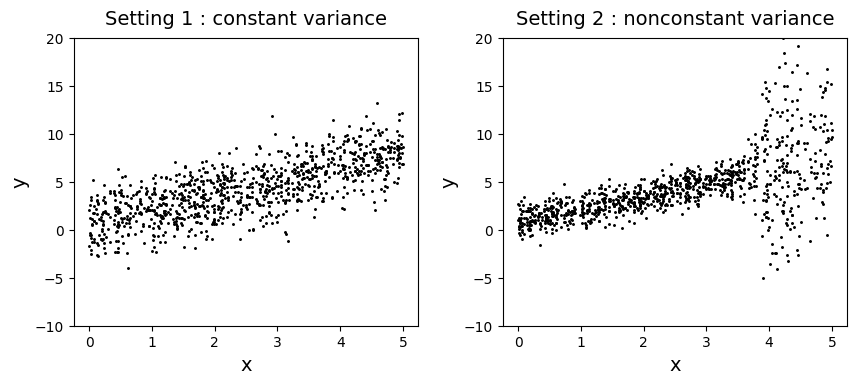

In [12]:
#scatterplot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,4))
fig.tight_layout(pad=3.0)
Y0_vec_1 = np.array(list(Y0_tilde_constant_residual.values())).flatten()
X0_vec_1 = np.repeat(X0_constant_residual, 2)
ax1.scatter(X0_vec_1,Y0_vec_1,marker='.',color='black',s=5)
ax1.set_ylim([-10,20])
ax1.set_title("Setting 1 : constant variance",fontsize=14,pad=10)
ax1.set_xlabel('x',fontsize=14)
ax1.set_ylabel('y',fontsize=14)
Y0_vec_2 = np.array(list(Y0_tilde_nonconstant_residual.values())).flatten()
X0_vec_2 = np.repeat(X0_nonconstant_residual, 2)
ax2.scatter(X0_vec_2,Y0_vec_2,marker='.',color='black',s=5)
ax2.set_ylim([-10,20])
ax2.set_title("Setting 2 : nonconstant variance",fontsize=14,pad=10)
ax2.set_xlabel('x',fontsize=14)
ax2.set_ylabel('y',fontsize=14)

fig.show()
#fig.savefig(('scatterplot.png'),dpi=400,bbox_inches='tight')

#### Plots

##### Figure 3

/tmp/ipykernel_9502/3122011544.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


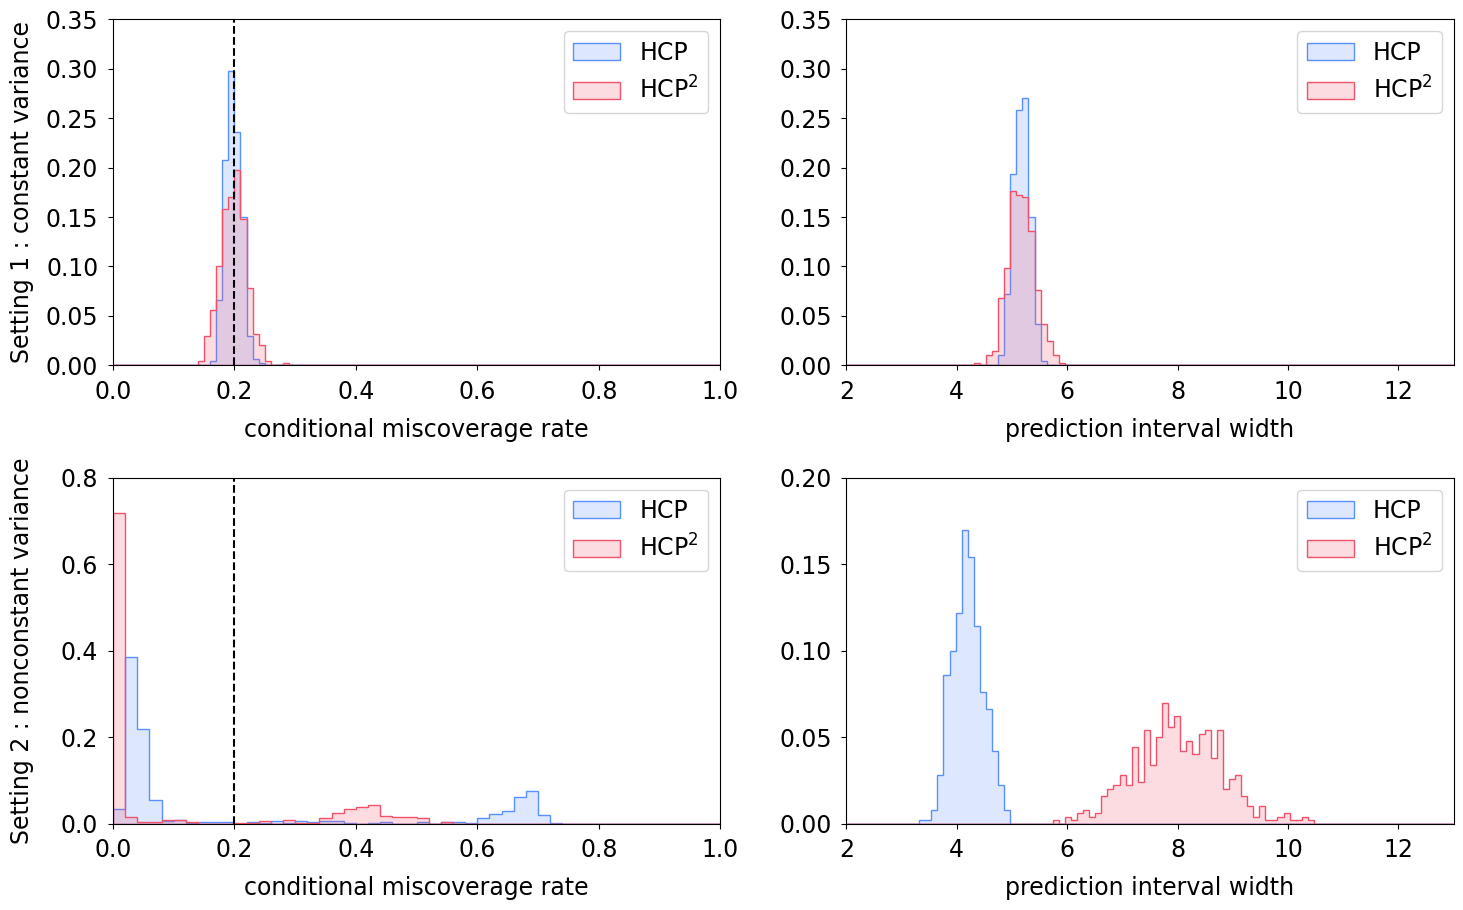

In [13]:
#Figure 3
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15.5,10))
fig.tight_layout(pad=6.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.35])
grid_prob = np.linspace(0,1,101)
n_t = 500
ax1.hist(output[0,:,0], grid_prob, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[1,:,0], grid_prob, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax1.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=17, pad=7)
ax1.tick_params(axis='y', labelsize=17, pad=7)
ax1.set_ylabel("Setting 1 : constant variance",fontsize=17, labelpad=15)
ax1.legend(loc='upper right',fontsize=17)
ax1.vlines(0.2,ymin=0,ymax=0.4,linestyles="dashed",color="black")
ax1.get_yaxis().set_label_coords(-0.13,0.5)

ax2.set_xlim([2, 13])
ax2.set_ylim([0, 0.35])
grid_width = np.linspace(2,13,101)
ax2.hist(2*output[3,:,0], grid_width, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[4,:,0], grid_width, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax2.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax2.tick_params(axis='x', labelsize=17, pad=7)
ax2.tick_params(axis='y', labelsize=17, pad=7)
ax2.legend(loc='upper right',fontsize=17)

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 0.8])
grid_prob = np.linspace(0,1,51)
ax3.hist(output[0,:,1], grid_prob, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[1,:,1], grid_prob, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax3.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax3.tick_params(axis='x', labelsize=17, pad=7)
ax3.tick_params(axis='y', labelsize=17, pad=7)
ax3.set_ylabel("Setting 2 : nonconstant variance",fontsize=17, labelpad=15)
ax3.legend(loc='upper right',fontsize=17)
ax3.vlines(0.2,ymin=0,ymax=0.8,linestyles="dashed",color="black")
ax3.get_yaxis().set_label_coords(-0.13,0.5)

grid_width = np.linspace(2, 13,101)
ax4.set_xlim([2, 13])
ax4.set_ylim([0, 0.2])
ax4.hist(2*output[3,:,1], grid_width, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[4,:,1], grid_width, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax4.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax4.tick_params(axis='x', labelsize=17, pad=7)
ax4.tick_params(axis='y', labelsize=17, pad=7)
ax4.legend(loc='upper right',fontsize=17)

fig.show()
#fig.savefig(('hist_residual.png'),dpi=400,bbox_inches='tight')

##### Figure 4

/tmp/ipykernel_9502/362496032.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


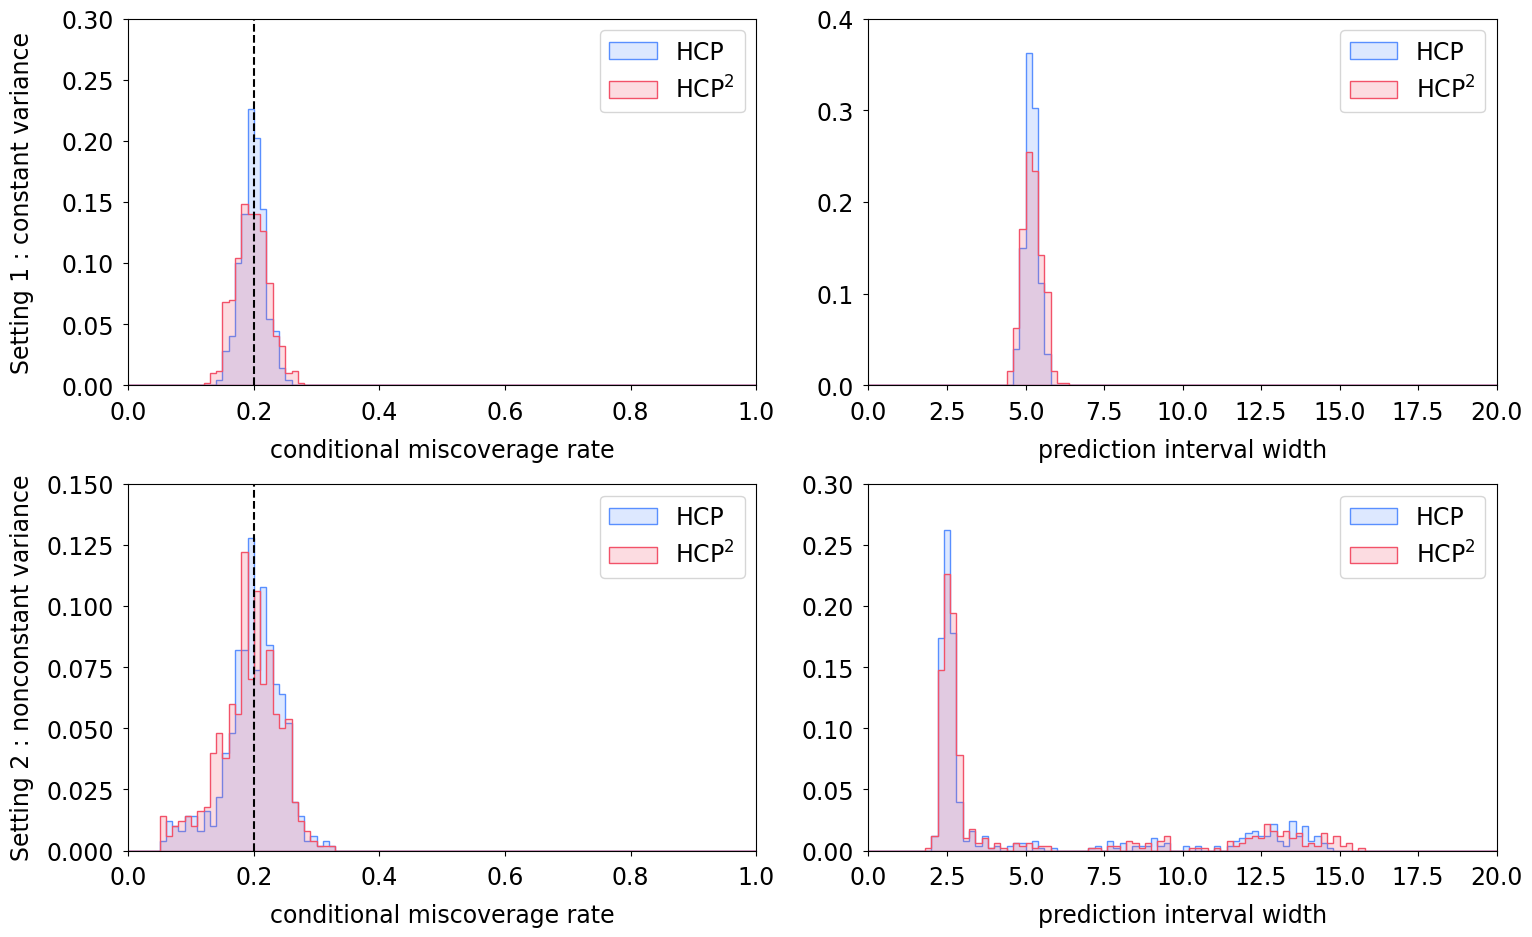

In [14]:
#Figure 4
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15.5,10))
fig.tight_layout(pad=5.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.3])
grid_prob = np.linspace(0,1,101)
n_t = 500
ax1.hist(output[0,:,2], grid_prob, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[1,:,2], grid_prob, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax1.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=17, pad=7)
ax1.tick_params(axis='y', labelsize=17, pad=7)
ax1.set_ylabel("Setting 1 : constant variance",fontsize=17, labelpad=15)
ax1.legend(loc='upper right',fontsize=17)
ax1.vlines(0.2,ymin=0,ymax=0.3,linestyles="dashed",color="black")
ax1.get_yaxis().set_label_coords(-0.15,0.5)

ax2.set_xlim([0,20])
ax2.set_ylim([0, 0.4])
grid_width = np.linspace(0,20,101)
ax2.hist(2*output[3,:,2], grid_width, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[4,:,2], grid_width, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax2.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax2.tick_params(axis='x', labelsize=17, pad=7)
ax2.tick_params(axis='y', labelsize=17, pad=7)
ax2.legend(loc='upper right',fontsize=17)

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 0.15])
grid_prob = np.linspace(0,1,101)
ax3.hist(output[0,:,3], grid_prob, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[1,:,3], grid_prob, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax3.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax3.tick_params(axis='x', labelsize=17, pad=7)
ax3.tick_params(axis='y', labelsize=17, pad=7)
ax3.set_ylabel("Setting 2 : nonconstant variance",fontsize=17, labelpad=15)
ax3.legend(loc='upper right',fontsize=17)
ax3.vlines(0.2,ymin=0,ymax=0.35,linestyles="dashed",color="black")
ax3.get_yaxis().set_label_coords(-0.15,0.5)

grid_width = np.linspace(0,20,101)
ax4.set_xlim([0,20])
ax4.set_ylim([0, 0.3])
ax4.hist(2*output[3,:,3], grid_width, label="HCP",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[4,:,3], grid_width, label="HCP$^2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax4.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax4.tick_params(axis='x', labelsize=17, pad=7)
ax4.tick_params(axis='y', labelsize=17, pad=7)
ax4.legend(loc='upper right',fontsize=17)

fig.show()
#fig.savefig(('hist_rescaled_residual.png'),dpi=400,bbox_inches='tight')

##### Figure 5

/tmp/ipykernel_9502/39878948.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


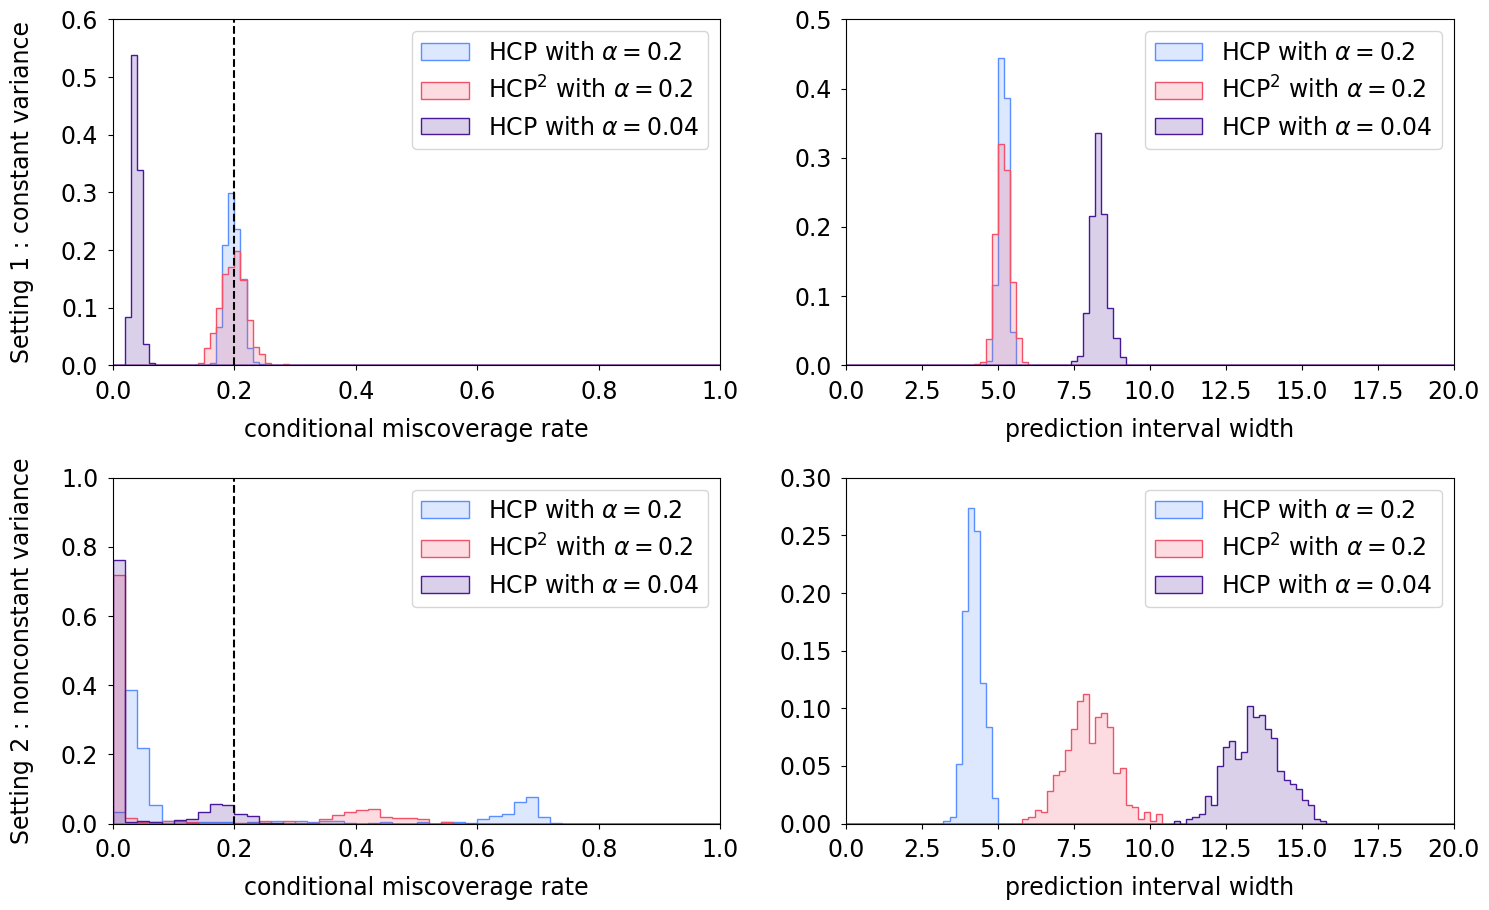

In [15]:
#Figure 5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15.5,10))
fig.tight_layout(pad=6.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.6])
grid_prob = np.linspace(0,1,101)
n_t = 500
ax1.hist(output[0,:,0], grid_prob, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[1,:,0], grid_prob, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[2,:,0], grid_prob, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax1.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=17, pad=7)
ax1.tick_params(axis='y', labelsize=17, pad=7)
ax1.set_ylabel("Setting 1 : constant variance",fontsize=17, labelpad=15)
ax1.legend(loc='upper right',fontsize=17)
ax1.vlines(0.2,ymin=0,ymax=0.6,linestyles="dashed",color="black")
ax1.get_yaxis().set_label_coords(-0.13,0.5)

ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.5])
grid_width = np.linspace(0,20,101)
ax2.hist(2*output[3,:,0], grid_width, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[4,:,0], grid_width, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[5,:,0], grid_width, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax2.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax2.tick_params(axis='x', labelsize=17, pad=7)
ax2.tick_params(axis='y', labelsize=17, pad=7)
ax2.legend(loc='upper right',fontsize=17)

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
grid_prob = np.linspace(0,1,51)
n_t = 500
ax3.hist(output[0,:,1], grid_prob, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[1,:,1], grid_prob, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[2,:,1], grid_prob, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax3.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax3.tick_params(axis='x', labelsize=17, pad=7)
ax3.tick_params(axis='y', labelsize=17, pad=7)
ax3.set_ylabel("Setting 2 : nonconstant variance",fontsize=17, labelpad=15)
ax3.legend(loc='upper right',fontsize=17)
ax3.vlines(0.2,ymin=0,ymax=1,linestyles="dashed",color="black")
ax3.get_yaxis().set_label_coords(-0.13,0.5)

grid_width = np.linspace(0,20,101)
ax4.set_xlim([0, 20])
ax4.set_ylim([0, 0.3])
ax4.hist(2*output[3,:,1], grid_width, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[4,:,1], grid_width, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[5,:,1], grid_width, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax4.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax4.tick_params(axis='x', labelsize=17, pad=7)
ax4.tick_params(axis='y', labelsize=17, pad=7)
ax4.legend(loc='upper right',fontsize=17)

fig.show()
#fig.savefig(('hist_residual_app.png'),dpi=400,bbox_inches='tight')

##### Figure 6

/tmp/ipykernel_9502/2927405425.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


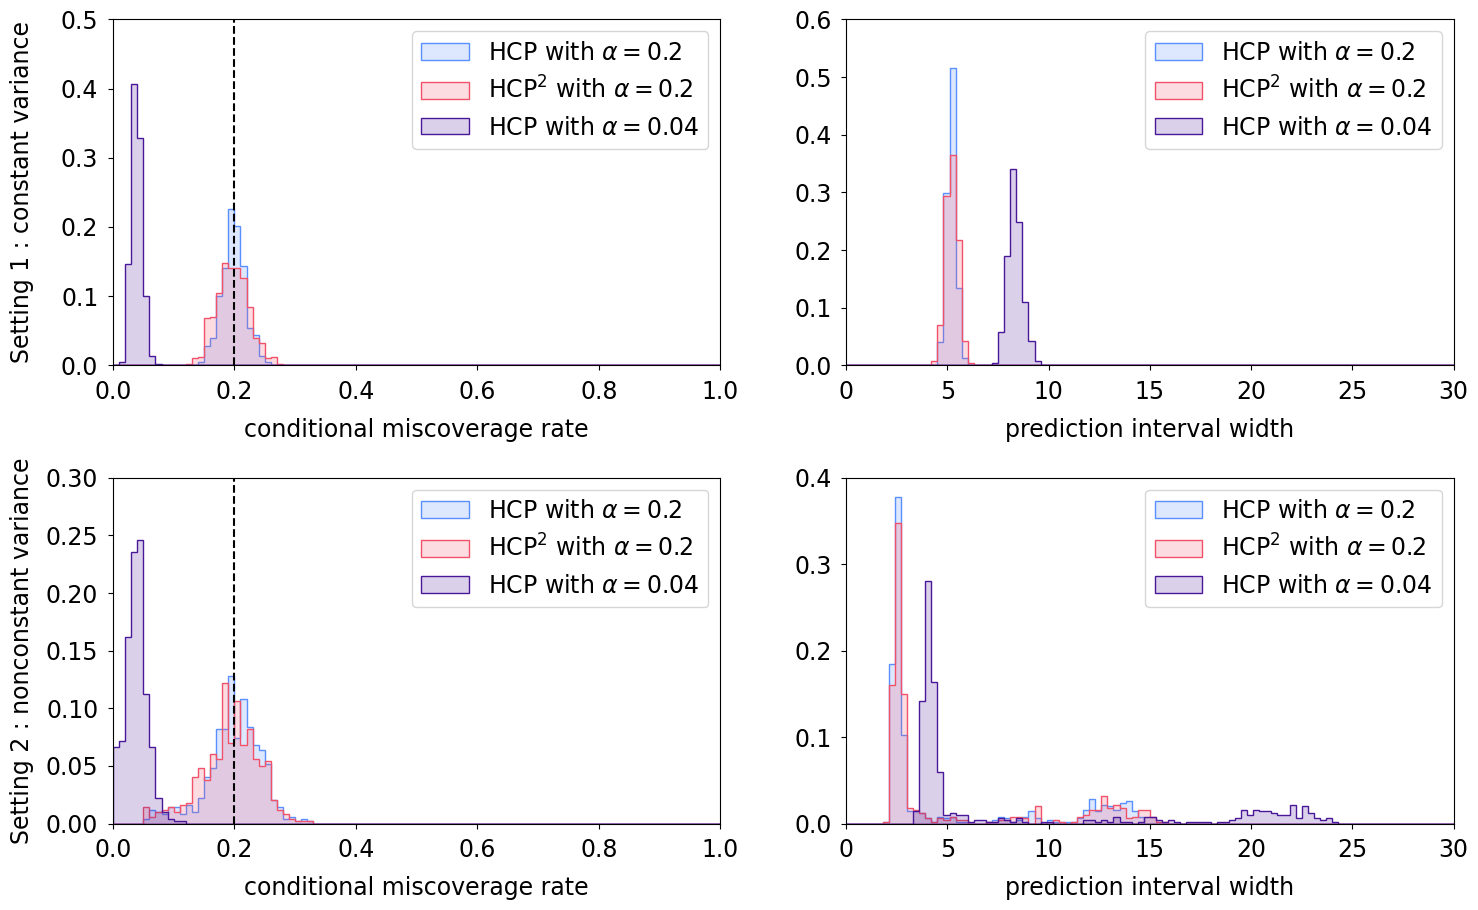

In [16]:
#Figure 6
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15.5,10))
fig.tight_layout(pad=6.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.5])
grid_prob = np.linspace(0,1,101)
n_t = 500
ax1.hist(output[0,:,2], grid_prob, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[1,:,2], grid_prob, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax1.hist(output[2,:,2], grid_prob, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax1.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax1.tick_params(axis='x', labelsize=17, pad=7)
ax1.tick_params(axis='y', labelsize=17, pad=7)
ax1.set_ylabel("Setting 1 : constant variance",fontsize=17, labelpad=15)
ax1.legend(loc='upper right',fontsize=17)
ax1.vlines(0.2,ymin=0,ymax=0.6,linestyles="dashed",color="black")
ax1.get_yaxis().set_label_coords(-0.13,0.5)

ax2.set_xlim([0, 30])
ax2.set_ylim([0, 0.6])
grid_width = np.linspace(0,30,101)
ax2.hist(2*output[3,:,2], grid_width, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[4,:,2], grid_width, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax2.hist(2*output[5,:,2], grid_width, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax2.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax2.tick_params(axis='x', labelsize=17, pad=7)
ax2.tick_params(axis='y', labelsize=17, pad=7)
ax2.legend(loc='upper right',fontsize=17)

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 0.3])
grid_prob = np.linspace(0,1,101)
ax3.hist(output[0,:,3], grid_prob, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[1,:,3], grid_prob, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax3.hist(output[2,:,3], grid_prob, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax3.set_xlabel("conditional miscoverage rate",fontsize=17, labelpad=10)
ax3.tick_params(axis='x', labelsize=17, pad=7)
ax3.tick_params(axis='y', labelsize=17, pad=7)
ax3.set_ylabel("Setting 2 : nonconstant variance",fontsize=17, labelpad=15)
ax3.legend(loc='upper right',fontsize=17)
ax3.vlines(0.2,ymin=0,ymax=1,linestyles="dashed",color="black")
ax3.get_yaxis().set_label_coords(-0.13,0.5)

grid_width = np.linspace(0,30,101)
ax4.set_xlim([0, 30])
ax4.set_ylim([0, 0.4])
ax4.hist(2*output[3,:,3], grid_width, label=r"HCP with $\alpha=0.2$",histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[4,:,3], grid_width, label=r"HCP$^2$ with $\alpha=0.2$",histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(n_t)/n_t)
ax4.hist(2*output[5,:,3], grid_width, label=r"HCP with $\alpha=0.04$",histtype='stepfilled',color=(0.282,0.094,0.6,0.2),edgecolor = (0.282,0.094,0.6,1),weights=np.ones(n_t)/n_t)
ax4.set_xlabel("prediction interval width",fontsize=17, labelpad=10)
ax4.tick_params(axis='x', labelsize=17, pad=7)
ax4.tick_params(axis='y', labelsize=17, pad=7)
ax4.legend(loc='upper right',fontsize=17)

fig.show()
#fig.savefig(('hist_rescaled_residual_app.png'),dpi=400,bbox_inches='tight')

#### Tables

In [17]:
print(np.around(np.mean(output[0:3,:,:],axis=1),4))

[[0.1979 0.2017 0.1985 0.1982]
 [0.1983 0.1011 0.1965 0.1917]
 [0.0385 0.0405 0.0391 0.0384]]


In [18]:
print(np.around(np.std(output[0:3,:,:],axis=1)/np.sqrt(500),4))

[[0.0006 0.0118 0.0009 0.002 ]
 [0.0009 0.0079 0.0012 0.0022]
 [0.0003 0.0034 0.0004 0.0008]]


In [19]:
print(np.around(np.mean(output[0:3,:,:]**2,axis=1),4))

[[0.0393 0.1108 0.0398 0.0414]
 [0.0398 0.0413 0.0393 0.0391]
 [0.0015 0.0073 0.0016 0.0018]]


In [20]:
print(np.around(np.std(output[0:3,:,:]**2,axis=1)/np.sqrt(500),4))

[[0.0002 0.0084 0.0003 0.0008]
 [0.0004 0.0034 0.0005 0.0008]
 [0.     0.0007 0.     0.0001]]
